In [1]:
from snorkel.labeling import labeling_function
import json
import os
import numpy as np

# Defining the Labelers

In [2]:
POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

@labeling_function()
def llava_7b(image_name):
    root_path = '../prompting_framework/prompting_results/hateful/total_results/'
    llava_7b_results = 'llava:7b_results_hateful.json'
    path_to_llava_7b_results = os.path.join(root_path,llava_7b_results)
    with open(path_to_llava_7b_results, 'r') as file:
        data = json.load(file)

    return data[image_name] if data[image_name] is not None else -1

@labeling_function()
def llava_13b(image_name):
    root_path = '../prompting_framework/prompting_results/hateful/total_results/'
    llava_7b_results = 'llava 13b-allsamples-results.json'
    path_to_llava_7b_results = os.path.join(root_path,llava_7b_results)
    with open(path_to_llava_7b_results, 'r') as file:
        data = json.load(file)

    return data[image_name] if data[image_name] is not None else -1

@labeling_function()
def bakllava(image_name):
    root_path = '../prompting_framework/prompting_results/hateful/total_results/'
    llava_7b_results = 'bakllava-allsamples-results.json'
    path_to_llava_7b_results = os.path.join(root_path,llava_7b_results)
    with open(path_to_llava_7b_results, 'r') as file:
        data = json.load(file)

    return data[image_name] if data[image_name] is not None else -1

@labeling_function()
def llava_llama3(image_name):
    root_path = '../prompting_framework/prompting_results/hateful/total_results/'
    llava_7b_results = 'llava-llama3-allsamples-results.json'
    path_to_llava_7b_results = os.path.join(root_path,llava_7b_results)
    with open(path_to_llava_7b_results, 'r') as file:
        data = json.load(file)

    return data[image_name] if data[image_name] is not None else -1

@labeling_function()
def llava_phi3(image_name):
    root_path = '../prompting_framework/prompting_results/hateful/total_results/'
    llava_7b_results = 'llava-phi3-allsamples-results.json'
    path_to_llava_7b_results = os.path.join(root_path,llava_7b_results)
    with open(path_to_llava_7b_results, 'r') as file:
        data = json.load(file)

    return data[image_name] if data[image_name] is not None else -1


@labeling_function()
def moondream(image_name):
    root_path = '../prompting_framework/prompting_results/hateful/total_results/'
    llava_7b_results = 'moondream-allsamples-results.json'
    path_to_llava_7b_results = os.path.join(root_path,llava_7b_results)
    with open(path_to_llava_7b_results, 'r') as file:
        data = json.load(file)

    return data[image_name] if data[image_name] is not None else -1

@labeling_function()
def llava_34b(image_name):
    root_path = '../prompting_framework/prompting_results/hateful/total_results/'
    llava_7b_results = 'llava 34b-allsamples-results.json'
    path_to_llava_7b_results = os.path.join(root_path,llava_7b_results)
    with open(path_to_llava_7b_results, 'r') as file:
        data = json.load(file)

    return data[image_name] if data[image_name] is not None else -1

In [3]:
print(llava_34b("48132.png"))
print(llava_llama3("48132.png"))

0
0


# Train Dataset

In [4]:
train_data_json_path = '../prompting_framework/prompting_results/hateful/simplified_train.json'
dev_data_json_path = '../prompting_framework/prompting_results/hateful/simplified_dev.json'

with open(train_data_json_path, 'r') as file:
    train_data = json.load(file)

# Extract and pad image names, ensuring they are 5 digits long before the '.png'
train_image_names = []
for entry in train_data:
    img_name, ext = entry['img'].split('.')
    padded_img_name = img_name.zfill(5)  # Pad the image name to 5 digits
    train_image_names.append(f"{padded_img_name}.{ext}")

with open(dev_data_json_path, 'r') as file:
    dev_data = json.load(file)
    
dev_image_names = []
Y_dev = []
for entry in dev_data:
    Y_dev.append(entry['label'])
    img_name, ext = entry['img'].split('.')
    padded_img_name = img_name.zfill(5)  # Pad the image name to 5 digits
    dev_image_names.append(f"{padded_img_name}.{ext}")

print(f"There are {len(train_image_names)} images in the Train set.")
print(f"There are {len(dev_image_names)} images in the dev set.")
print(f"There are {len(Y_dev)} labels in the dev set.")


There are 8500 images in the Train set.
There are 500 images in the dev set.
There are 500 labels in the dev set.


# Applying the LFs

In [5]:
from snorkel.labeling import LFApplier

list_of_all_the_models = ['moondream',
       'llava_34b',
        'llava_13b',
       'llava_phi3',
       'bakllava',
       'llava_7b',
       'llava_llama3'
       ]

lfs = [moondream,
       llava_34b,
       llava_13b,
       llava_phi3,
       bakllava,
       llava_7b,
       llava_llama3
       ]

applier = LFApplier(lfs)

In [6]:
from snorkel.labeling import LFAnalysis

L_dev = applier.apply(dev_image_names)
L_train = applier.apply(train_image_names)

500it [00:04, 110.02it/s]
8500it [01:03, 134.65it/s]


In [7]:
Y_dev = np.array(Y_dev)
LFAnalysis(L_dev, lfs).lf_summary(Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
moondream,0,"[0, 1]",1.00,1.00,0.752,246,254,0.492000
llava_34b,1,"[0, 1]",1.00,1.00,0.752,269,231,0.538000
llava_13b,2,"[0, 1]",1.00,1.00,0.752,288,212,0.576000
llava_phi3,3,"[0, 1]",0.99,0.99,0.744,267,228,0.539394
bakllava,4,"[0, 1]",0.95,0.95,0.710,276,199,0.581053
llava_7b,5,"[0, 1]",1.00,1.00,0.752,298,202,0.596000
llava_llama3,6,"[0, 1]",1.00,1.00,0.752,278,222,0.556000


F1 of the labelers:

In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def calculate_metrics(y_true, y_pred, abstain_class=-1):
    # Filter out samples where prediction is -1
    valid_indices = y_pred != abstain_class
    y_true_filtered = y_true[valid_indices]
    y_pred_filtered = y_pred[valid_indices]

    # Compute metrics
    conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)
    precision = precision_score(y_true_filtered, y_pred_filtered)
    recall = recall_score(y_true_filtered, y_pred_filtered)
    f1 = f1_score(y_true_filtered, y_pred_filtered)
    accuracy = accuracy_score(y_true_filtered, y_pred_filtered)

    return {
        'Confusion Matrix': conf_matrix,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy': accuracy
    }

Visualization:

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

# Example ground truth and predictions for six models
# Replace these arrays with actual predictions from each model
y_true = Y_dev
predictions = {}

for i in range(L_dev.shape[1]):
    predictions[list_of_all_the_models[i]] = L_dev[:,i]
    
# Create a DataFrame to store confusion matrix results and metrics
confusion_data = []

for model_name, y_pred in predictions.items():
    
    y_pred = np.array(y_pred)
    # Confusion Matrix
    metrics = calculate_metrics(Y_dev, y_pred)
    
    tn, fp, fn, tp = metrics['Confusion Matrix'].ravel()
    precision = metrics['Precision']
    recall = metrics['Recall']
    f1 = metrics['F1 Score']
    accuracy = metrics['Accuracy']
    # Append data
    confusion_data.append([
        model_name, tn, fp, fn, tp, 
        recall, precision, accuracy, f1
    ])

# Convert to a DataFrame for display
confusion_df = pd.DataFrame(confusion_data, columns=[
    'Model', 'True Negative', 'False Positive', 'False Negative', 'True Positive', 
    'Recall', 'Precision', 'Accuracy', 'F1 Score'
])

# Display the table with confusion matrix and metrics
confusion_df


,Model,True Negative,False Positive,False Negative,True Positive,Recall,Precision,Accuracy,F1 Score
0,moondream,238,12,242,8,0.032000,0.400000,0.492000,0.059259
1,llava_34b,241,9,222,28,0.112000,0.756757,0.538000,0.195122
2,llava_13b,175,75,137,113,0.452000,0.601064,0.576000,0.515982
3,llava_phi3,143,107,121,124,0.506122,0.536797,0.539394,0.521008
4,bakllava,164,72,127,112,0.468619,0.608696,0.581053,0.529551
5,llava_7b,144,106,96,154,0.616000,0.592308,0.596000,0.603922
6,llava_llama3,103,147,75,175,0.700000,0.543478,0.556000,0.611888


# Majority Vote Results

In [12]:
def majority_vote(labels):
    # Assuming the labels are categorical and using mode to find the most frequent label
    from scipy.stats import mode
    # Using mode along axis=1 to find the most common element across columns
    modes = mode(labels, axis=1)
    # modes.mode contains the most common values, reshaping to (500,) for a clean 1D array output
    return modes.mode.reshape(-1)

# Applying the majority vote function
majority_labels = majority_vote(L_dev)

In [14]:
metrics = calculate_metrics(Y_dev, majority_labels)
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Confusion Matrix: [[182  68]
 [143 107]]
Precision: 0.6114285714285714
Recall: 0.428
F1 Score: 0.5035294117647059
Accuracy: 0.578


# Optimization for Label Model

In [10]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=False)
label_model.fit(L_train, Y_dev, n_epochs=5000, log_freq=500, seed=12345)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3688.17epoch/s]


In [11]:
from snorkel.analysis import metric_score
from snorkel.utils import probs_to_preds

probs_dev = label_model.predict_proba(L_dev)
preds_dev = probs_to_preds(probs_dev)

metrics = calculate_metrics(Y_dev, preds_dev)
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Confusion Matrix: [[159  91]
 [121 129]]
Precision: 0.5863636363636363
Recall: 0.516
F1 Score: 0.548936170212766
Accuracy: 0.576


In [92]:
L_train.shape[1]

7

Experimenting with different number of LFs

In [12]:
all_f1s = []
number_of_epochs = 1000
for i in range(3, L_train.shape[1]+1):

    
    label_model = LabelModel(cardinality=2, verbose=False)
    label_model.fit(L_train[:,:i], Y_dev, n_epochs=number_of_epochs, log_freq=500, seed=12)
    
    probs_dev = label_model.predict_proba(L_dev[:,:i])
    preds_dev = probs_to_preds(probs_dev)

    metrics = calculate_metrics(Y_dev, preds_dev)
    all_f1s.append(metrics['F1 Score'])
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print(f'trained with the LFs = {list_of_all_the_models[:i]}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3847.33epoch/s]


Confusion Matrix: [[172  78]
 [135 115]]
Precision: 0.5958549222797928
Recall: 0.46
F1 Score: 0.5191873589164786
Accuracy: 0.574
trained with the LFs = ['moondream', 'llava_34b', 'llava_13b']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3928.83epoch/s]


Confusion Matrix: [[185  65]
 [162  88]]
Precision: 0.5751633986928104
Recall: 0.352
F1 Score: 0.43672456575682383
Accuracy: 0.546
trained with the LFs = ['moondream', 'llava_34b', 'llava_13b', 'llava_phi3']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3934.48epoch/s]


Confusion Matrix: [[162  88]
 [131 119]]
Precision: 0.5748792270531401
Recall: 0.476
F1 Score: 0.5207877461706784
Accuracy: 0.562
trained with the LFs = ['moondream', 'llava_34b', 'llava_13b', 'llava_phi3', 'bakllava']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3803.68epoch/s]


Confusion Matrix: [[178  72]
 [131 119]]
Precision: 0.6230366492146597
Recall: 0.476
F1 Score: 0.5396825396825397
Accuracy: 0.594
trained with the LFs = ['moondream', 'llava_34b', 'llava_13b', 'llava_phi3', 'bakllava', 'llava_7b']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3735.29epoch/s]

Confusion Matrix: [[159  91]
 [121 129]]
Precision: 0.5863636363636363
Recall: 0.516
F1 Score: 0.548936170212766
Accuracy: 0.576
trained with the LFs = ['moondream', 'llava_34b', 'llava_13b', 'llava_phi3', 'bakllava', 'llava_7b', 'llava_llama3']


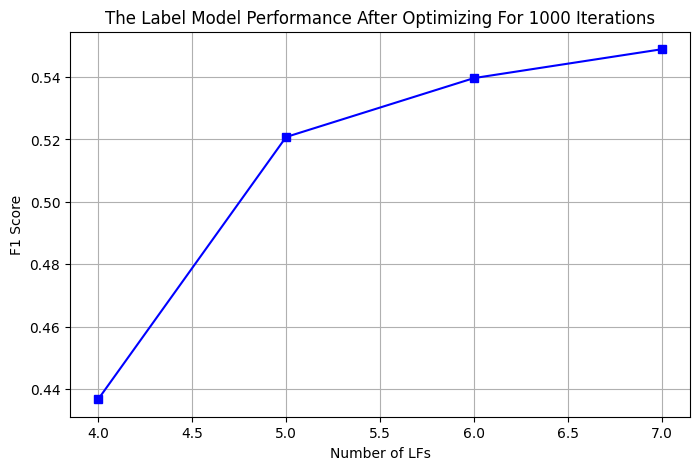

In [13]:
import matplotlib.pyplot as plt
x = np.array([4, 5, 6, 7])

plt.figure(figsize=(8, 5))
plt.plot(x, all_f1s[1:], marker='s', linestyle='-', color='b')
plt.title(f'The Label Model Performance After Optimizing For {number_of_epochs} Iterations')
plt.xlabel('Number of LFs')
plt.ylabel('F1 Score')
plt.grid(True)
# plt.savefig('HM_LM_1000_4-7.png')
plt.show()

In [14]:
all_f1s[1:]

[0.43672456575682383,
 0.5207877461706784,
 0.5396825396825397,
 0.548936170212766]

# Training the End Model

The dataloader for PyTorch

In [12]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, image_names, root_dir, labels, target_dists, transform=None):
        """
        Args:
            image_names (list): List of image file names.
            root_dir (string): Directory where images are stored.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_names = image_names
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform
        self.target_dists = target_dists

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Build the full path of the image file
        img_name = os.path.join(self.root_dir, self.image_names[idx])
        label = self.labels[idx]
        target_dist = self.target_dists[idx]
        image = Image.open(img_name).convert('RGB')  # Load image as RGB

        # Apply any transformations (e.g., resize, normalization)
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label), torch.tensor(target_dist)

In [13]:
root_dir = "/home1/pupil/goowfd/CVPR_2025/hateful_memes/img/"

transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224 (example)
        transforms.ToTensor(),          # Convert images to PyTorch tensors
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean/std
    ])

probs_dev = label_model.predict_proba(L_train)
label_model_predictions = probs_to_preds(probs_dev)

In [14]:
dataset = ImageDataset(image_names=train_image_names, 
                       root_dir=root_dir, 
                       labels=label_model_predictions, 
                       target_dists=probs_dev, 
                       transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

dev_dataset = ImageDataset(image_names=dev_image_names, 
                           root_dir=root_dir, 
                           labels=Y_dev, 
                           target_dists=probs_dev, 
                           transform=transform)
dev_dataloader = DataLoader(dev_dataset, batch_size=8, shuffle=False, num_workers=4)

A basic ResNet

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn.functional as F

def expected_cross_entropy_loss(logits, target_distributions):
    """
    Computes the expected cross-entropy loss for a batch of predictions and target distributions.

    Parameters:
    logits (torch.Tensor): The raw output from the model of shape (batch_size, num_classes).
    target_distributions (torch.Tensor): The target class distributions of shape (batch_size, num_classes),
                                         where each row is a probability distribution over classes.

    Returns:
    torch.Tensor: The expected cross-entropy loss.
    """
    # Convert logits to log probabilities
    log_probs = F.log_softmax(logits, dim=1)
    
    # Compute the element-wise product between target distributions and log probabilities
    # Then, sum across classes to get the cross-entropy for each instance
    cross_entropy = -torch.sum(target_distributions * log_probs, dim=1)
    
    # Take the mean over the batch
    loss = cross_entropy.mean()
    
    return loss

class MLPHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPHead, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Pretrained ResNet with MLP head for binary classification
class ResNetWithMLP(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetWithMLP, self).__init__()
        # Load a pretrained ResNet (e.g., ResNet18)
        self.resnet = models.resnet18(pretrained=True)
        
        # Freeze the ResNet layers if you don't want to train them
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the last fully connected layer with a custom MLP head
        num_features = self.resnet.fc.in_features  # Get the number of features in the last layer
        self.resnet.fc = MLPHead(input_dim=num_features, output_dim=num_classes)

    def forward(self, x):
        return self.resnet(x)

In [1]:
model = ResNetWithMLP(num_classes=2)

NameError: name 'ResNetWithMLP' is not defined

In [17]:
from tqdm import tqdm
# Function to evaluate the model on the dev set
def evaluate(model, dev_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels, target_dist in tqdm(dev_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass to get outputs
            outputs = model(images)

            # Get predictions (class with the highest score)
            _, predicted = torch.max(outputs.data, 1)

            # Store true labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)
    
def train(model, train_loader, dev_dataloader, criterion, optimizer, device, epochs):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels, target_dist in tqdm(train_loader):
            images, labels, target_dist = images.to(device), labels.to(device), target_dist.to(device)

            optimizer.zero_grad()  # Clear the gradients

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            # loss = expected_cross_entropy_loss(outputs, target_dist)

            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights

            # Calculate running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
        labels, predictions = evaluate(model, dev_dataloader, device)

        # Calculate and print precision, recall, and F1-score
        # calculate_metrics(labels, predictions)
        metrics = calculate_metrics(labels, predictions)
        for metric, value in metrics.items():
            print(f"{metric}: {value}")


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Binary classification loss
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.0001)  # Only optimize the MLP parameters

# Train the model
epochs = 10
train(model, dataloader, dev_dataloader, criterion, optimizer, device, epochs)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:19<00:00, 54.11it/s]


Epoch [1/10], Loss: 0.6636, Accuracy: 59.96%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 50.80it/s]


Confusion Matrix: [[172  78]
 [161  89]]
Precision: 0.5329341317365269
Recall: 0.356
F1 Score: 0.42685851318944845
Accuracy: 0.522


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:20<00:00, 51.97it/s]


Epoch [2/10], Loss: 0.6271, Accuracy: 65.45%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 51.08it/s]


Confusion Matrix: [[ 85 165]
 [ 68 182]]
Precision: 0.5244956772334294
Recall: 0.728
F1 Score: 0.609715242881072
Accuracy: 0.534


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:18<00:00, 57.56it/s]


Epoch [3/10], Loss: 0.6078, Accuracy: 67.06%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 51.16it/s]


Confusion Matrix: [[136 114]
 [127 123]]
Precision: 0.5189873417721519
Recall: 0.492
F1 Score: 0.5051334702258727
Accuracy: 0.518


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:17<00:00, 60.40it/s]


Epoch [4/10], Loss: 0.5874, Accuracy: 69.24%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 52.43it/s]


Confusion Matrix: [[156  94]
 [135 115]]
Precision: 0.5502392344497608
Recall: 0.46
F1 Score: 0.5010893246187363
Accuracy: 0.542


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:17<00:00, 61.78it/s]


Epoch [5/10], Loss: 0.5638, Accuracy: 70.84%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 53.60it/s]


Confusion Matrix: [[103 147]
 [ 95 155]]
Precision: 0.5132450331125827
Recall: 0.62
F1 Score: 0.5615942028985508
Accuracy: 0.516


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:16<00:00, 62.72it/s]


Epoch [6/10], Loss: 0.5268, Accuracy: 73.28%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 54.88it/s]


Confusion Matrix: [[166  84]
 [146 104]]
Precision: 0.5531914893617021
Recall: 0.416
F1 Score: 0.4748858447488584
Accuracy: 0.54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:16<00:00, 63.19it/s]


Epoch [7/10], Loss: 0.4769, Accuracy: 77.02%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 53.58it/s]


Confusion Matrix: [[161  89]
 [149 101]]
Precision: 0.531578947368421
Recall: 0.404
F1 Score: 0.4590909090909091
Accuracy: 0.524


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:17<00:00, 61.53it/s]


Epoch [8/10], Loss: 0.4215, Accuracy: 80.65%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 35.18it/s]


Confusion Matrix: [[157  93]
 [138 112]]
Precision: 0.5463414634146342
Recall: 0.448
F1 Score: 0.49230769230769234
Accuracy: 0.538


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:17<00:00, 59.25it/s]


Epoch [9/10], Loss: 0.3579, Accuracy: 84.29%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 52.34it/s]


Confusion Matrix: [[134 116]
 [128 122]]
Precision: 0.5126050420168067
Recall: 0.488
F1 Score: 0.5
Accuracy: 0.512


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:17<00:00, 61.80it/s]


Epoch [10/10], Loss: 0.2996, Accuracy: 87.41%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 53.58it/s]

Confusion Matrix: [[153  97]
 [131 119]]
Precision: 0.5509259259259259
Recall: 0.476
F1 Score: 0.5107296137339056
Accuracy: 0.544


Evaluation ...

In [29]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Function to evaluate the model on the dev set
def evaluate(model, dev_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels, target_dist in tqdm(dev_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass to get outputs
            outputs = model(images)

            # Get predictions (class with the highest score)
            _, predicted = torch.max(outputs.data, 1)

            # Store true labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Function to calculate precision, recall, and F1 score
def calculate_metrics(labels, predictions):
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return precision, recall, f1

In [31]:
dev_dataset = ImageDataset(image_names=dev_image_names, root_dir=root_dir, labels=Y_dev, target_dists=probs_dev, transform=transform)
dev_dataloader = DataLoader(dev_dataset, batch_size=8, shuffle=False, num_workers=4)

In [33]:
labels, predictions = evaluate(model, dev_dataloader, device)

# Calculate and print precision, recall, and F1-score
# calculate_metrics(labels, predictions)
metrics = calculate_metrics(labels, predictions)
for metric, value in metrics.items():
    print(f"{metric}: {value}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 55.81it/s]

Precision: 0.5355
Recall: 0.4520
F1 Score: 0.4902


AttributeError: 'tuple' object has no attribute 'items'

Training the CLIP+MLP model